# Notebook for Infrared-Collinear Safe Graph Neural Networks on Point Clouds

## Project Proposal

In recent years, machine learning has revolutionized the field of particle physics.
Whether used directly in a physical apparatus or as a data-driven tool for uncovering
patterns in nature, experimentalists and theorists alike have greatly benefited from
machine learning. At accelerators such as the LHC, high energy collisions produce
fundamental particles that fragment into a shower of composite particles. To apply
machine learning techniques to these events, two questions must be answered: 1) how
to represent the event, and 2) how to analyze this representation. Since collision
events are inherently unordered sets of particles, they are often treated as point
clouds.

Of particular interest to theorists are a class of observables that are IRC safe,
meaning they are insensitive to low energy particles (InfraRed) or parallel particles
carrying the same total energy (Collinear). IRC safe observables are important
because they are the only observables that can be calculated in perturbative quantum
field theory and are more robust to detector effects. In the point cloud representation,
IRC safety can be enforced in a neural network architecture known as Energy Flow
Networks, offering an effcient learning scheme for IRC safe observables.

Over the past 3 years, graph neural networks (GNNs) have become a powerful
tool in a wide variety of applications, such as material science, drug discovery, social
network analysis, and combinatorial optimization. Recently, the GNN framework has
been applied to point clouds, offering a powerful method for classiffcation tasks
in jet physics by exploiting local spatial structure in particle clouds. Although
this method has shown considerable effectiveness in jet classiffcation tasks, since IRC
safety is not enforced, it has suboptimal performance on regression tasks. The goal of this project is to implement IRC safety in the point cloud GNN
architecture, allowing effcient and effective prediction of IRC safe observables from
collider events. This will build on the Energy Flow Networks scheme by accounting
for pairwise relationships between particles while retaining IRC safety.

## Import Libraries

In [2]:
import torch_scatter, torch_sparse, torch_cluster, torch_geometric
import matplotlib.pyplot as plt
import math as m
import random

## Visualization Functions

In [192]:
# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()
    
def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

## Import Example Dataset

GeometricShapes(40)
Data(face=[3, 30], pos=[32, 3], y=[1])


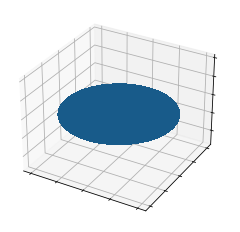

In [207]:
from torch_geometric.datasets import GeometricShapes

dataset = GeometricShapes(root='data/GeometricShapes')
print(dataset)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

## Create Point Cloud

Data(pos=[50, 3], y=[1])


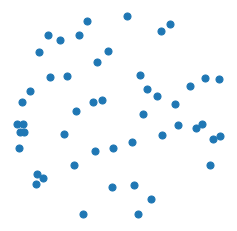

In [208]:
import torch
from torch_geometric.transforms import SamplePoints

torch.manual_seed(42)

dataset.transform = SamplePoints(num=50)

data = dataset[0]
print(data)
visualize_points(data.pos, data.edge_index)

## Create K-NN Graph

torch.Size([2, 150])


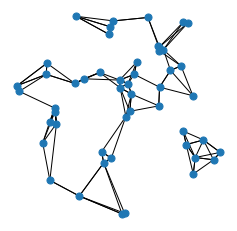

In [387]:
from torch_cluster import knn_graph

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=3)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

In [333]:
nn_array = data.edge_index.numpy()

nn = {}

for i in range(len(neighbors_array[0])):
    if nn_array[1, i] not in nn.keys():
        nn[nn_array[1, i]] = [nn_array[0, i]]
    else:
        nn[nn_array[1, i]].append(nn_array[0, i])

## Infrared-Collinear Safe Edge Convolutions

The main task is enforcing IRC-safety in the edge convolution operation from [Dynamic Graph CNN for Learning on Point Clouds](https://arxiv.org/pdf/1801.07829.pdf). By weighting the pairwise nonlinear function with the neighboring particle's energy, the operation is IRC-safe:

$$x_i' = \sum\limits_{j:(i, j) \in E} z_j \cdot h_\theta(x_i, x_j),$$

where $z_j$ is the energy of particle $j$ and $h_\theta$ is a nonlinear function with learnable parameters $\theta$.

However, we need a way to build a IRC-safe graph.

In [397]:
def collinear(p, z):
    """
    Input:
    p: angular vectors array
    z: energy array
    neighbors: nearest neighbors dictionary for each particle
    
    Output:
    p_split and z_split, where a random particle is chosen for collinear splitting (same angular vector, additive energy splitting)
    
    """
    i = random.randint(0, len(p) - 1)
    lam = random.random()
    
    p_split = np.vstack((p, p[i]))
    z_split = z + [(1 - lam) * z[i]]
    z_split[i] = lam * z_split[i]
    
    print("Split on particle", i)
    
    return p_split, z_split

In [450]:
def infrared(p, z):
    """
    Input:
    p: angular vectors array
    z: energy array
    neighbors: nearest neighbors dictionary for each particle
    
    Output:
    p_split and z_split, where a random particle is chosen for collinear splitting (same angular vector, additive energy splitting)
    
    """
    
    p_new = np.random.rand(*p[0].shape)
    
    p_IR = np.vstack((p, p_new))
    z_IR = z + [0]
    
    return p_IR, z_IR

In [438]:
# zs = [random.random() for i in range(50)]

# p_split, z_split = collinear(data.pos.numpy(), zs)

Split on particle 2


In [452]:
# p_IR, z_IR = infrared(data.pos.numpy(), zs)

In [360]:
# C1_new = []
# for i in range(len(C1_split)):
#     C1_new += [sum([z1_split[j] * np.exp(C1_split[i] + C1_split[j]) for j in range(len(C1_split))])]
    

# for i in range(len(C1_new)):
#     print(sum([z1_split[j] * np.exp(C1_new[i] + C1_new[j]) for j in range(len(C1_new))]))

In [361]:
# def energy_conv_cluster(C, z, h):
#     """
#     Inputs:
#         C - cluster of particles from KNN graph
#         z - energy of particles in the cluster
#         h - nonlinear function
    
#     Outputs:
#         convd - array representing convolved edges
#     """
    
#     convd = []
    
#     for i in range(len(C)):
#         convd += [(sum([z[j] * h(C[i], C[j]) for j in range(len(C))]))]
    
#     return convd

In [400]:
def energy_conv(p, z, neighbors, h):
    """
    Inputs:
        p - set of particles spatial information
        z - energy of particles in the cluster
        neighbors - set of neighbors for each particle
        h - nonlinear function
    
    Outputs:
        convd - array representing convolved edges
    """
    
    convd = []
    
    for i in range(len(p)):
        p_convd = 0
        nn_s = neighbors[i]
        for j in nn_s:
            p_convd += z[j] * h(p[i], p[j])
        
        convd += [p_convd]
    
    return convd

In [365]:
# def h(x1, x2):
#     return np.exp(x1 * x2)

In [431]:
# energy_conv(p_split, z_split, nn_split, h)[37]

array([1.0841497, 0.5290673, 0.5009121], dtype=float32)

In [432]:
# energy_conv(data.pos.numpy(), zs, nn, h)[37]

array([0.24359158, 0.32495332, 0.3143675 ], dtype=float32)

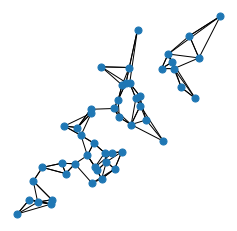

In [396]:
# visualize_points(X, X_edge)

In [425]:
X_edge = knn_graph(torch.from_numpy(p_split), k=3)
X_edge

tensor([[31, 28, 30, 31,  0, 30,  9, 29, 10, 32, 19, 48, 46, 36, 15, 15, 42, 36,
         43, 26, 20, 40, 17, 12, 23, 33, 45,  2, 46, 10, 29, 47, 41, 42, 34, 49,
         13,  7, 14, 30, 12, 26, 35,  7, 12,  5, 42,  4, 21, 18, 38, 40, 45,  7,
         16, 21, 46, 48, 32,  3, 43,  6, 28, 16, 38, 18, 38, 21, 44,  8, 33, 45,
         39, 27, 37, 48, 34,  3, 40, 13,  6, 39, 24, 37, 30, 31,  0, 10, 41, 47,
         28, 13, 31,  0, 28, 30,  3, 19, 48, 23, 22, 44, 49, 39, 11, 49, 14, 48,
         44, 38,  4, 50, 41, 47, 22, 21, 16, 27, 24, 34, 17, 26,  7, 47, 10, 29,
         15, 11,  5, 20,  6, 26, 36, 38, 22, 17, 40, 44,  4,  9, 18, 41, 10, 29,
         19,  3, 35, 35, 34, 11, 37, 41, 47],
        [ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
          6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
         12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
         18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22

In [427]:
nn_array = X_edge.numpy()

nn_split = {}

for i in range(len(nn_array[0])):
    if nn_array[1, i] not in nn_split.keys():
        nn_split[nn_array[1, i]] = [nn_array[0, i]]
    else:
        nn_split[nn_array[1, i]].append(nn_array[0, i])

import energyflow as ef
import numpy as np
import torch

### GNN Model with Fully Connected Graph

In [45]:
import energyflow as ef
import numpy as np
import torch

import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
from torch.nn import MSELoss
from sklearn.model_selection import train_test_split

from torch_cluster import knn_graph
from torch_geometric.data import Data, DataLoader

from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing

In [60]:
train_size, val_size, test_size = 1000, 100, 100
X, y = ef.qg_jets.load(train_size + val_size + test_size, ncol=3, pad=False)

print('Loaded quark and gluon jets')

Loaded quark and gluon jets


In [61]:
# preprocess by centering jets and normalizing pts
event_mask = []
for x in X:
    mask = x[:,0] > 0
    event_mask.append(np.count_nonzero(mask) > 1)
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()
X = X[np.asarray(event_mask)]

print('Finished preprocessing')

Finished preprocessing


In [62]:
# compute the jet "mass" as an angularity with exponent 2
# it's easier for the network to predict the log of the observable, shifted and scaled
obs = np.log10(np.asarray([np.sum(x[:,0]*(x[:,1:3]**2).sum(1))/x[:,0].sum() for x in X]))
obs_mean, obs_std = np.mean(obs), np.std(obs)
obs -= obs_mean
obs /= obs_std

print('Finished computing observables')

Finished computing observables


## Create Dataset with Padded Array

In [63]:
# from torch_cluster import knn_graph
# from torch_geometric.data import Data, DataLoader

# def CreateDataset(p, z, y):
#     Dataset = []

#     for i in range(len(p)):
#         p = torch.Tensor(p_train[i])
#         z = torch.Tensor([z_train[i]]).T
#         y = torch.Tensor([y_train[i]]).T

#         # create fully-connected graph for each particle
#         edge_index = knn_graph(p, k=len(p))

#         # directed energy edge weights - define for IRC safe convolution
#         Z_weight = torch.Tensor([[z[i][0] for i in edge_index[0]]]).T

#         # be careful - Dataloader turns edge_attribute into a list of [[Z_weight], [Z]]
#         data = Data(p, edge_index, edge_attribute=[Z_weight, z], y=y)
        

#         Dataset.append(data)
    
#     return DataLoader(Dataset, batch_size=1)

## Create Dataset with non-Padded Array

In [64]:
def CreateDataset(X, y):
    Dataset = []

    for i in range(len(X)):
        p = torch.Tensor(X[i][:, 1:])
        z = torch.Tensor([X[i][:, 0]]).T
        m = torch.Tensor([y[i]]).T

        # create fully-connected graph for each particle
        edge_index = knn_graph(p, k=len(p))

        # directed energy edge weights - define for IRC safe convolution
        Z_weight = torch.Tensor([[z[i][0] for i in edge_index[0]]]).T

        # be careful - Dataloader turns edge_attribute into a list of [[Z_weight], [Z]]
        data = Data(p, edge_index, edge_attribute=[Z_weight, z], y=m)
        
        Dataset.append(data)
        
    train, test = train_test_split(list(range(len(Dataset))), test_size=int(0.1*len(Dataset)))
        
    train, val = train_test_split(train, test_size=int(0.1*len(Dataset)))
    
    train_set = [Dataset[i] for i in train]
    val_set = [Dataset[i] for i in val]
    test_set = [Dataset[i] for i in test]
    
    return DataLoader(train_set, batch_size=1), DataLoader(val_set, batch_size=1), DataLoader(test_set, batch_size=1)

## Train/Val/Test Split on Dataset

In [65]:
train_loader, test_loader, val_loader = CreateDataset(X, obs)

In [66]:
# train_loader = CreateDataset(p_train, z_train, y_train)
# val_loader = CreateDataset(p_val, z_val, y_val)
# test_loader = CreateDataset(p_test, z_test, y_test)

## Create the IRC Safe Edge-Convolution Class

In [67]:
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing

class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(EdgeConv, self).__init__(aggr='add') #  "Add" aggregation.
        self.mlp = Seq(Linear(2 * in_channels, out_channels),
                       ReLU(),
                       Linear(out_channels, out_channels))

    def forward(self, x, edge_index, edge_weight):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_i, x_j, edge_weight):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]
        
        tmp = torch.cat([x_i, x_j], dim=1)  # tmp has shape [E, 2 * in_channels]

        return self.mlp(tmp) * edge_weight

## Build Neural Network Architecture

### Base Model

In [68]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = EdgeConv(2, 8)
        self.mlp2 = Seq(Linear(8, 16),
                       ReLU(),
                       Linear(16, 8),
                       ReLU(),
                       Linear(8, 1))

    def forward(self, data):
        x, edge_index, edge_weight, energy = data.x, data.edge_index, data.edge_attribute[0][0], data.edge_attribute[0][1]

        x = self.conv1(x, edge_index, edge_weight)
        x = self.mlp2(x)
        
        # scale each particle's latent rep by it's energy, then sum
        return (x.T @ energy).reshape(-1)

### Mini-Batching Model, still need to figure out

In [69]:
# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = EdgeConv(2, 8)
# #         self.conv2 = EdgeConv(16, 8)
# #         self.conv3 = EdgeConv(8, 4)
#         self.mlp2 = Seq(Linear(8, 16),
#                        ReLU(),
#                        Linear(16, 8),
# #                        ReLU(),
# #                        Linear(8, 4),
#                        ReLU(),
#                        Linear(8, 1))

#     def forward(self, data):
#         x, edge_index, edge_weight, energy = data.x, data.edge_index, data.edge_attribute[0][0], data.edge_attribute[0][1]
        
# #         edge_weight = torch.cat([data.edge_attribute[i][0] for i in range(len(data.edge_attribute))])
# #         energy =  torch.cat([data.edge_attribute[i][1] for i in range(len(data.edge_attribute))])


#         x = self.conv1(x, edge_index, edge_weight)
# #         x = self.conv2(x, edge_index, edge_weight)
# #         x = F.relu(x)
# #         x = F.dropout(x, training=self.training)
# #         x = self.conv2(x, edge_index, edge_weight)
# #         x = F.relu(x)
# #         x = self.conv3(x, edge_index, edge_weight)
#         x = self.mlp2(x)

# #         dot = (x.T @ energy).reshape(-1)
# #         out = []
# #         ind1 = 0
# #         for i in range(len(data.edge_attribute)):
# #             ind2 = ind1 + len(data.edge_attribute[i][1])
# #             out.append([torch.sum(dot[ind1:ind2])])
# #             ind1 = ind2
        
# #         out = torch.Tensor(out)
        
# #         print(out.shape)
        
#         # scale each particle's latent rep by it's energy, then sum
#         return (x.T @ energy).reshape(-1)

In [70]:
def trainer(model, device, train_loader, optimizer, val_loader=None):
    model.train()
    
    total_loss = 0
    total_items = 0
    
    targ = []
    pred = []
    
    with torch.enable_grad():
        for data in train_loader:

            targ.append(float(data.y[0]))

            optimizer.zero_grad()

            output = model.forward(data)
            
            pred.append(float(output))

            loss_fn = MSELoss()
            loss = loss_fn(output, data.y[0])      

            loss.backward()
            optimizer.step()


            total_loss += loss
            total_items += len(data)

    accuracy = pearsonr(targ, pred)[0]
    
    return total_loss.item()/len(train_loader), accuracy.item()

In [71]:
def tester(model, device, train_loader, testing=False):
    model.eval()
    
    total_loss = 0
    total_items = 0
    
    targ = []
    pred = []
   
    with torch.no_grad():
        for data in train_loader:

            targ.append(float(data.y))

            output = model.forward(data)

            pred.append(float(output))

            loss = F.mse_loss(output, data.y)

            total_loss += loss
            total_items += len(data)
    
    accuracy = pearsonr(targ, pred)[0]
    
    return total_loss.item()/len(train_loader), accuracy.item()


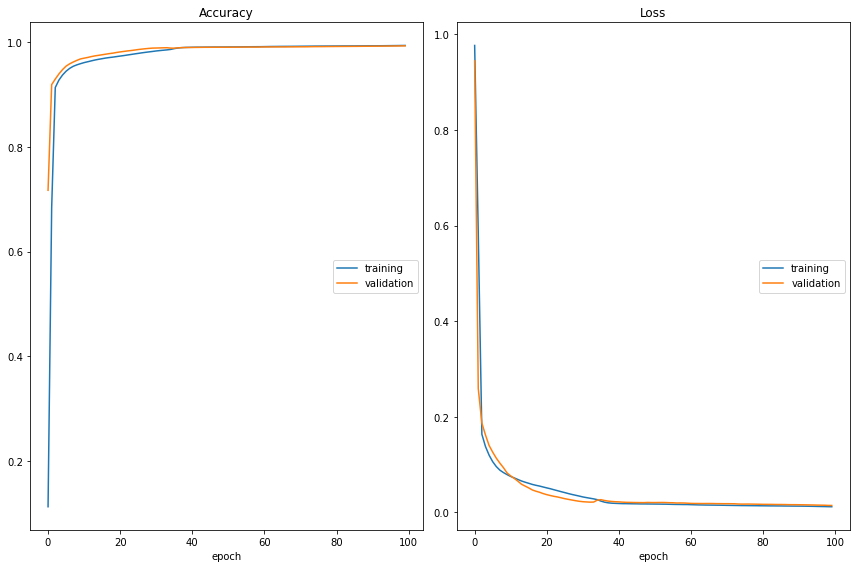

Accuracy
	training         	 (min:    0.112, max:    0.994, cur:    0.994)
	validation       	 (min:    0.717, max:    0.993, cur:    0.993)
Loss
	training         	 (min:    0.012, max:    0.977, cur:    0.012)
	validation       	 (min:    0.014, max:    0.945, cur:    0.014)


In [72]:
from livelossplot import PlotLosses

# check if running on CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize a fully-connected classifier
fc_model = Net()

# initialize our optimizer. We'll use Adam
# optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001, weight_decay=0.01)
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)

plotlosses = PlotLosses()

for epoch in range(100):
    train_loss, train_acc = trainer(fc_model, device, train_loader, optimizer)
    val_loss, val_acc = tester(fc_model, device, val_loader)
    
    plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
    plotlosses.draw()  # draw, update logs, etc

In [58]:
test_loss, test_acc = tester(fc_model, device, test_loader, True)
print('\n\t\t\tTest Loss: {:.6f} \t Test Accuracy: {:.6f}'.format(test_loss, test_acc) )


			Test Loss: 0.003803 	 Test Accuracy: 0.998350


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [257]:
model.train()

Net(
  (conv1): EdgeConv(
    (mlp): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
    )
  )
  (conv2): EdgeConv(
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1, out_features=1, bias=True)
    )
  )
)

In [268]:
for epoch in range(1000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()

In [269]:
model.eval()
# _, pred = model(data).max(dim=1)
pred = model(data)
pred, data.y
# correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
# acc = correct / int(data.test_mask.sum())
# print('Accuracy: {:.4f}'.format(acc * 100))

(tensor([-0.5525], grad_fn=<ViewBackward>), tensor([-0.5527]))